# Predicting Bankruptcy in Taiwan Using Gradient Boosting Trees.


In the previous notebook, I used an ensemble model named random forest to extend the analysis done  with the decision tree and  saw that the random forest model performed better .Now I'll be considering another type of ensemble model called the gradient boosting tree model.

In [21]:
import gzip
import json
import pickle

import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from ipywidgets import interact
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from teaching_tools.widgets import ConfusionMatrixWidget

# Prepare Data

## Import

I'll import the wrangle function I created in the previous notebook.

In [3]:
# import our wrangle function created in the previous notebook
def wrangle(filename):
    # open compressed file,load into dict
    with gzip.open(filename,"r") as f:
        data = json.load(f)
        
    # turn dict into dataframe
    df = pd.DataFrame().from_dict(data["observations"]).set_index("id")
    
    return df

In [4]:
df = wrangle("data/taiwan-bankruptcy-data.json.gz")
print("df shape:", df.shape)
df.head()

df shape: (6137, 96)


,bankrupt,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,feat_94,feat_95
id,,,,,,,,,,,,,,,,,,,,,
1,True,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
2,True,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
3,True,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
4,True,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
5,True,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


## Split

I'll Create my feature matrix X and target vector y. my target is "bankrupt".

In [5]:
target = "bankrupt"
X = df.drop(columns=target)
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (6137, 95)
y shape: (6137,)


Now i'll divide my data (X and y) into training and test sets using a randomized train-test split. my test set is 20% of my total data.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4909, 95)
y_train shape: (4909,)
X_test shape: (1228, 95)
y_test shape: (1228,)


## Resample

Remember the data is imbalanced so I need to resample. I am  going to use the over sampling method because from the previous task it yielded a better accuracy score.

In [7]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (9512, 95)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,feat_94,feat_95
0,0.535855,0.599160,0.594411,0.627099,0.627099,0.999220,0.797686,0.809591,0.303518,0.781865,...,0.834091,0.022025,0.624364,0.627101,0.841977,0.275384,0.026791,0.565158,1,0.147943
1,0.554136,0.612734,0.595000,0.607388,0.607388,0.999120,0.797614,0.809483,0.303600,0.781754,...,0.840293,0.002407,0.624548,0.607385,0.842645,0.276532,0.026791,0.565158,1,0.062544
2,0.549554,0.603467,0.599122,0.620166,0.620166,0.999119,0.797569,0.809470,0.303524,0.781740,...,0.840403,0.000840,0.624010,0.620163,0.842873,0.277249,0.026800,0.565200,1,0.047929
3,0.543801,0.603249,0.606992,0.622515,0.622515,0.999259,0.797728,0.809649,0.303510,0.781930,...,0.831514,0.006176,0.626775,0.622513,0.842989,0.280013,0.026839,0.565375,1,0.028386
4,0.498659,0.562364,0.546978,0.603670,0.603670,0.998904,0.797584,0.809459,0.304000,0.781713,...,0.811988,0.004256,0.623674,0.603669,0.841105,0.277628,0.026897,0.565618,1,0.043080


# Build Model

## Baseline

In [8]:
# Calculate the baseline accuracy score for my model.
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9688


## Iterate

Ensemble models work by building multiple models on random subsets of the same data, and then comparing their predictions to make a final prediction. Since I used a random forest trees in the last project, we're going to be considering the gradient boosting tree here.

Now I'll Create a pipeline named clf (short for "classifier") that contains a GradientBoostingClassifier predictor.

In [9]:
clf = GradientBoostingClassifier(random_state=42)
print(clf)

GradientBoostingClassifier(random_state=42)


Remember while Iwas doing this that I only want to be looking at the positive class. Here, the positive class is the one where the companies really did go bankrupt. 

Next, I am going to tune some of the hyperparameters for my model.

In [10]:
# Create a dictionary with the range of hyperparameters that we want to evaluate for our classifier
params = {
    "n_estimators": range(20,31,5),
    "max_depth":  range(2,5)
}
params

{'n_estimators': range(20, 31, 5), 'max_depth': range(2, 5)}

Note that I am trying much smaller numbers of n_estimators. This is because GradientBoostingClassifier is slower to train than the RandomForestClassifier.

Next I'll Create a GridSearchCV named model that includes my classifier and hyperparameter grid.

GridSearchCV takes as input a model, a grid of hyperparameter values to search over, a cross-validation strategy, and a performance metric to optimize for. It then trains and evaluates the model for each possible combination of hyperparameters in the grid, using cross-validation to estimate the performance of each combination. Finally, it returns the hyperparameters that achieved the highest performance according to the specified metric.

Overall, GridSearchCV is a powerful tool for finding the best hyperparameters for a given machine learning model, and it can help to improve the accuracy and generalization of the model.

In [11]:
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1

)
model

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(2, 5),
                         'n_estimators': range(20, 31, 5)},
             verbose=1)

Now that I have everything i need for the model, I'll fit it to the data and see.

In [12]:
# Fit model to over-sampled training data
model.fit(X_train_over,y_train_over)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(2, 5),
                         'n_estimators': range(20, 31, 5)},
             verbose=1)

Next I'll Extract the cross-validation results from model and load them into a DataFrame named cv_results.

Cross-validation is a technique used in machine learning to evaluate the performance of a model on unseen data. The basic idea is to split the available data into several subsets or folds, train the model on a portion of the data (the training set), and then test it on the remaining data (the validation set). This process is repeated multiple times, with different subsets of data used for training and validation each time. The results from each fold are then averaged to give an estimate of the model's performance on unseen data.

In [13]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.088136,0.007476,0.004577,0.000189,2,20,"{'max_depth': 2, 'n_estimators': 20}",0.909616,0.897530,0.903260,0.905363,0.906414,0.904437,0.004017,9
1,5.121241,0.038522,0.004798,0.000312,2,25,"{'max_depth': 2, 'n_estimators': 25}",0.912769,0.913820,0.917455,0.913775,0.912198,0.914004,0.001832,8
2,6.151623,0.041161,0.004723,0.000178,2,30,"{'max_depth': 2, 'n_estimators': 30}",0.923279,0.917499,0.916930,0.923239,0.919558,0.920101,0.002723,7
3,5.865593,0.044609,0.029694,0.030563,3,20,"{'max_depth': 3, 'n_estimators': 20}",0.929585,0.930636,0.932177,0.934805,0.931651,0.931771,0.001758,6
4,7.337993,0.044213,0.004765,0.000160,3,25,"{'max_depth': 3, 'n_estimators': 25}",0.935365,0.931687,0.939537,0.937434,0.935331,0.935871,0.002605,5
5,8.840607,0.068041,0.042153,0.030436,3,30,"{'max_depth': 3, 'n_estimators': 30}",0.941146,0.940620,0.943218,0.942166,0.943743,0.942179,0.001185,4
6,7.677375,0.115437,0.017132,0.024343,4,20,"{'max_depth': 4, 'n_estimators': 20}",0.959538,0.955859,0.957413,0.961094,0.955836,0.957948,0.002075,3
7,9.545967,0.044977,0.017779,0.025921,4,25,"{'max_depth': 4, 'n_estimators': 25}",0.959538,0.961114,0.957939,0.965825,0.962671,0.961417,0.002710,2
8,11.674530,0.219133,0.005378,0.000724,4,30,"{'max_depth': 4, 'n_estimators': 30}",0.965318,0.963216,0.963197,0.967928,0.964248,0.964781,0.001757,1


Next, I'll look at the hyperparameters that led to the best performance.

In [14]:
# Extract best hyperparameters
best_model_par = model.best_params_
model_best_score = model.best_score_

print(f" the best model paramters is : {best_model_par}")
print(f" the model best score is : {model_best_score}")


 the best model paramters is : {'max_depth': 4, 'n_estimators': 30}
 the model best score is : 0.9647814370248315


# Evaluate

Now that I have a working model that's actually giving us something useful, I'll  like to see  how good it really is.

In [15]:
# Calculate the accuracy score for my model 
acc_train =  model.score(X_train,y_train)
acc_test = model.score(X_test,y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Validation Accuracy:", round(acc_test, 4))

Training Accuracy: 0.9466
Validation Accuracy: 0.9389


Just like before, I'll create a confusion matrix to see how my model is making its correct and incorrect predictions.

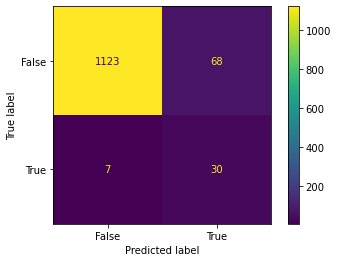

In [16]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model,X_test,y_test);

This matrix is a great reminder of how imbalanced my data is, and of why accuracy isn't always the best metric for judging whether or not a model is giving us what we want. After all, if 95% of the companies in our dataset didn't go bankrupt, all the model has to do is always predict {"bankrupt": False}, and it'll be right 95% of the time. The accuracy score will be amazing, but it won't tell us what we really need to know.

Instead, I can evaluate our model using two new metrics: precision and recall. The precision score is important when my model is to only predict that a company will go bankrupt if its very confident in its prediction. The recall score is important if I want to make sure to identify all the companies that will go bankrupt, even if that means being incorrect sometimes.

Next I'll Print the classification report for my model, using the test set.

In [17]:
# Print classification report
print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.99      0.94      0.97      1191
        True       0.31      0.81      0.44        37

    accuracy                           0.94      1228
   macro avg       0.65      0.88      0.71      1228
weighted avg       0.97      0.94      0.95      1228



Precision and recall are two common metrics used in machine learning to evaluate the performance of a binary classification model.

Precision is the fraction of true positive predictions (correctly predicted positive examples) among all positive predictions made by the model. In other words, it measures how accurate the model is when it predicts positive examples. A high precision indicates that the model is making few false positive predictions.

Recall, on the other hand, is the fraction of true positive predictions among all actual positive examples in the dataset. It measures how well the model can identify positive examples, regardless of how many false positives it may predict. A high recall indicates that the model is identifying a large proportion of the positive examples in the dataset.

In general, precision and recall are inversely related: increasing precision typically decreases recall and vice versa. A good balance between precision and recall is often desired, depending on the specific problem and application.

I'll create a confusion matrix containing precision and recall.

In [18]:
c = ConfusionMatrixWidget(model, X_test, y_test)
c.show()

FloatSlider(value=0.5, continuous_update=False, description='Threshold:', max=1.0)

Next I'll Create an interactive dashboard that shows how company profit and losses change in relationship to my model's probability threshold.I'll Start with the make_cnf_matrix function, which should calculate and print profit/losses, and display a confusion matrix. Then I'll create a FloatSlider thresh_widget that ranges from 0 to 1. Finally combine my function and slider in the interact function.

In [19]:
def make_cnf_matrix(threshold):
    y_pred_proba = model.predict_proba(X_test)[:,-1]
    y_pred = y_pred_proba > threshold
    conf_matrix = confusion_matrix(y_test,y_pred)
    tn,fp,fn,tp = conf_matrix.ravel()
    print(f"Profit:€{tp * 100_000_000}" )
    print(f"Losses:€{tp * 250_000_000}" )
    print(f"Sum:€{(tp * 100_000_000)+(tp * 250_000_000)}")
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred,colorbar=False)


thresh_widget = widgets.FloatSlider(min=0,max=1,value=0.5,step=0.05)

interact(make_cnf_matrix, threshold=thresh_widget);

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

# Communicate

Now I'll Create a bar chart with the 15 most important features for model.

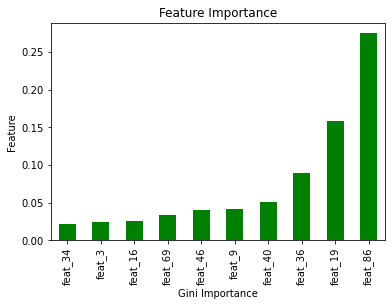

In [24]:
# Get feature names from training data
features = X_train_over.columns
# Extract importances from model
importances = importances = model.best_estimator_.feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances, index=features).sort_values()
# Plot 10 most important features
feat_imp.tail(10).plot(kind="bar",color ="g")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

Finally Using a context manager, I'll save my best-performing model to a a file named "model-Gradient-Boosting-Trees.pkl"

In [26]:
# Save your model as `"model-random-forest.pkl"`
with open("model-Gradient-Boosting-Trees.pkl","wb") as f:
    pickle.dump(model,f)